In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 384 (delta 120), reused 102 (delta 69), pack-reused 171
Receiving objects: 100% (384/384), 55.95 MiB | 30.08 MiB/s, done.
Resolving deltas: 100% (181/181), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=27640 sha256=321278122e3f0a809a950de92ae362e0593e9395f1e960072d755fa32f13f5f4
  Stored in directory: /tmp/pip-ephem-wheel-cache-pw9tnqr2/wheels/55/59/29/0fb1c635652

In [ ]:
from dul_2021.utils.hw12_utils import *

In [ ]:
import os
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib
from tqdm.notebook import tqdm


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt




import torchvision
from torchvision.datasets import STL10, CIFAR10
from torchvision import transforms

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from scipy.stats import mannwhitneyu
import numpy as np

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# Question 1. VAT

Here we will implement [VAT](https://arxiv.org/pdf/1704.03976.pdf).

* Train labeled data with standatd cross-entropy loss

* Use vat regularization for both unlabeled and labeled data

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* ξ= 10 
* lr = 5e-4
* num_epochs = 15



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [ ]:
class Net(nn.Module):
    def __init__(self, out_dim=128, hid_dim_full=128):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1, stride=2)
        self.conv5 = nn.Conv2d(32, 32, 1)
        self.conv6 = nn.Conv2d(32, 4, 1)

        self.conv_to_fc = 8 * 8 * 4
        self.fc1 = nn.Linear(self.conv_to_fc, hid_dim_full)
        self.fc2 = nn.Linear(hid_dim_full, int(hid_dim_full // 2))
        self.features = nn.Linear(int(hid_dim_full // 2), out_dim)
        self.last = nn.Linear(out_dim, 10)


    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))

        x = x.view(-1, self.conv_to_fc)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        features = self.features(x)

        return self.last(features)


class VAT(nn.Module):
    def __init__(self, xi=10):
        super(VAT, self).__init__()
        self.net = Net()
        self.xi = xi


    def forward(self, x):
        return self.net(x)


    def normalize(self, x):
        x_norm = x.reshape(x.shape[0], -1)
        x_norm = F.normalize(x_norm, dim=1)
        x_norm = x_norm.reshape(x.shape)
        return x_norm


    def get_supervised_loss(self, batch_x, batch_l):
        batch_x = batch_x.to(device).float()
        y_pred = self.net(batch_x)
        loss = F.cross_entropy(y_pred, batch_l.to(device))
        return loss


    def get_adversarial_loss(self, batch):
        batch_x, batch_l = batch
        batch_x = batch_x.to(device).float()
        with torch.no_grad():
            # θ_hat -- the vector of the model parameters at a 
            # specific iteration step of the training process. 
            y_pred = self.net(batch_x)
            y_pred = F.softmax(y_pred, dim=1)

        d = torch.randn(batch_x.shape).to(device)
        d = self.normalize(d) 
        r = self.xi * d
        r.requires_grad = True
        y_pred_ = self.net(batch_x + r)
        log_y_pred_ = F.log_softmax(y_pred_, dim=1)
        D_loss = F.kl_div(log_y_pred_, y_pred, reduction="batchmean")

        grad_r = torch.autograd.grad(outputs=D_loss,
                                     inputs=r,
                                     retain_graph=True,
                                     create_graph=True,)[0]
        r_vadv = self.normalize(grad_r).detach()
        self.net.zero_grad()

        y_pred_ = self.net(batch_x + r_vadv)
        log_y_pred_ = F.log_softmax(y_pred_, dim=1)
        loss = F.kl_div(log_y_pred_, y_pred, reduction="batchmean")
        return loss


    def get_accuracy(self, test_loader):
        accs = []
        self.net.eval()
        with torch.no_grad():
            for (x, l) in test_loader:
                p = self(x.to(device))
                pred_l = torch.argmax(p, dim=1).detach().cpu()
                acc = (pred_l == l).float().mean().item()
                accs.append(acc)
        return torch.Tensor(accs).mean()


    def fit(self, traindata, testdata, lr=5e-4, bs=256, num_epochs=15):
        optim = opt.Adam(self.parameters(), lr=lr)
        data_loader = torch.utils.data.DataLoader(traindata, bs, shuffle=True)
        test_loader = torch.utils.data.DataLoader(testdata, bs, shuffle=False)

        losses = []
        accs = []

        for i in tqdm(range(num_epochs)):
            for batch in tqdm(data_loader):
                l_mask = batch[1] != -1
                l_loss = self.get_supervised_loss(batch[0][l_mask], batch[1][l_mask])
                ul_loss = self.get_adversarial_loss(batch)
                loss = l_loss + ul_loss
                optim.zero_grad()
                loss.backward()
                optim.step()
                losses.append(loss.item())
            
            acc = self.get_accuracy(test_loader)
            print(f'Epoch {i + 1}, accuracy = {acc}')
            accs.append(acc)
        
        return np.array(losses), np.array(accs)

In [ ]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """

    model = VAT().to(device)
    losses, accs = model.fit(train_data, test_data, num_epochs=15)
    return losses, accs

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, accuracy = 0.26337891817092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, accuracy = 0.30927735567092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, accuracy = 0.3282226622104645


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, accuracy = 0.36894530057907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, accuracy = 0.3990234434604645


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, accuracy = 0.3876953125


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, accuracy = 0.42041015625


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, accuracy = 0.42255860567092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, accuracy = 0.41728514432907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, accuracy = 0.42509764432907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, accuracy = 0.41435545682907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, accuracy = 0.4189453125


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, accuracy = 0.42841798067092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, accuracy = 0.42431640625


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, accuracy = 0.41718751192092896


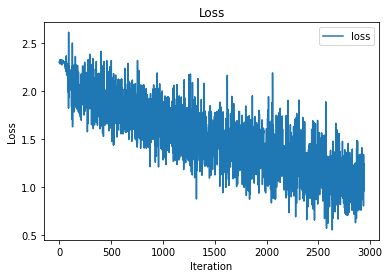

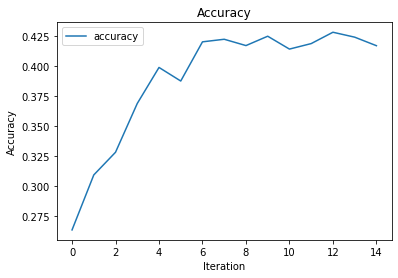

In [ ]:
q12_results(q1)

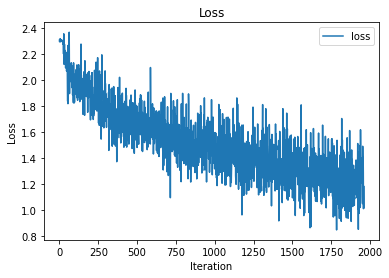

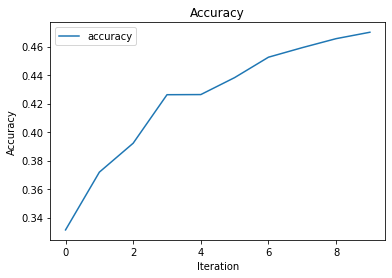

In [ ]:
q_results(q1) # ref

# Question 2. FixMatch

Here we will implement [FixMatch](https://arxiv.org/abs/2001.07685).

* Calculate loss on weakly augmented labeled data with standatd cross-entropy loss

* Calculate loss on strongly augmented unlabeled data with standatd cross-entropy loss with pseudo-lables

* Use SimCLR transformations as strong and RandomHorizontalFlip as weak

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* τ = 0.7 
* λ_u = 10 (weight of unlabeled loss)
* lr = 5e-4
* num_epochs ~ 20 or more



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [ ]:
# strong_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
#                                         transforms.ColorJitter(brightness=.5, hue=.3),
#                                         transforms.RandomResizedCrop(size=32),])
#                                         # transforms.ToTensor(),
#                                         # transforms.Normalize((0.5,), (0.5,))])

strong_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                        transforms.RandomGrayscale(p=0.3),
                                        transforms.RandomResizedCrop(size=32),])
                                        # transforms.ToTensor(),
                                        # transforms.Normalize((0.5,), (0.5,))])


weak_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),])
                                    #   transforms.ToTensor(),
                                    #   transforms.Normalize((0.5,), (0.5,))])

In [ ]:
class Net(nn.Module):
    def __init__(self, out_dim=128, hid_dim_full=128):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1, stride=2)
        self.conv5 = nn.Conv2d(32, 32, 1)
        self.conv6 = nn.Conv2d(32, 4, 1)

        self.conv_to_fc = 8 * 8 * 4
        self.fc1 = nn.Linear(self.conv_to_fc, hid_dim_full)
        self.fc2 = nn.Linear(hid_dim_full, int(hid_dim_full // 2))

        self.features = nn.Linear(int(hid_dim_full // 2), out_dim)
        self.last = nn.Linear(out_dim, 10)


    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))

        x = x.reshape(-1, self.conv_to_fc)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        features = self.features(x)

        return self.last(features)


class FixMatch(nn.Module):
    def __init__(self,):
        super(FixMatch, self).__init__()
        self.net = Net()


    def forward(self, x):
        return self.net(x)


    def get_accuracy(self, test_loader):
        accs = []
        self.net.eval()
        with torch.no_grad():
            for (x, l) in test_loader:
                p = self(x.to(device))
                pred_l = torch.argmax(p, dim=1).detach().cpu()
                acc = (pred_l == l).float().mean().item()
                accs.append(acc)
        return torch.Tensor(accs).mean()



    def fit(self, traindata, testdata, tau=0.7, lam_ul=10, lr=5e-4, bs=256, num_epochs=20):

        optim = opt.Adam(self.parameters(), lr=lr)
        data_loader = torch.utils.data.DataLoader(traindata, bs, shuffle=True)
        test_loader = torch.utils.data.DataLoader(testdata, bs, shuffle=False)

        losses = []
        accs = []
        
        for i in tqdm(range(num_epochs)):
            self.net.train()
            for (x, l) in tqdm(data_loader):
                ul_mask = l == -1

                # supervised part
                p = self(x[~ul_mask].to(device))
                l_loss = F.cross_entropy(p, l[~ul_mask].to(device))

                # unsupervised part
                strong_inp = strong_transforms(x[ul_mask]).to(device)
                weak_inp = weak_transforms(x[ul_mask]).to(device)
                p = self(weak_inp)
                hard_labels_mask = torch.max(F.softmax(p, dim=1), dim=1)[0] >= tau
                pseudo_l = F.one_hot(torch.argmax(p, dim=1), num_classes=10)
                ul_loss = F.cross_entropy(self(strong_inp[hard_labels_mask]),
                                          pseudo_l.float()[hard_labels_mask])

                loss = l_loss + lam_ul * ul_loss
                optim.zero_grad()
                loss.backward()
                optim.step()

                losses.append(loss.item())
            
            acc = self.get_accuracy(test_loader)
            print(f'Epoch {i + 1}, accuracy = {acc}')
            accs.append(acc)
        
        return np.array(losses), np.array(accs)

In [33]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """

    model = FixMatch().to(device)
    losses, accs = model.fit(train_data, test_data, lam_ul=3, num_epochs=30)
    return losses, accs

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, accuracy = 0.19863280653953552


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, accuracy = 0.23496094346046448


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, accuracy = 0.25419920682907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, accuracy = 0.27851563692092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, accuracy = 0.3065429627895355


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, accuracy = 0.29374998807907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, accuracy = 0.3231445252895355


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, accuracy = 0.26298826932907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, accuracy = 0.31513673067092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, accuracy = 0.30810546875


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, accuracy = 0.3001953065395355


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, accuracy = 0.22441406548023224


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, accuracy = 0.2850585877895355


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, accuracy = 0.2548828125


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, accuracy = 0.29472655057907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16, accuracy = 0.33935546875


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17, accuracy = 0.3109374940395355


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18, accuracy = 0.27324217557907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19, accuracy = 0.3145507872104645


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20, accuracy = 0.17333984375


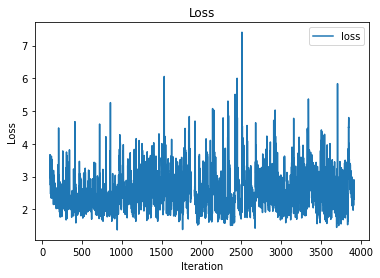

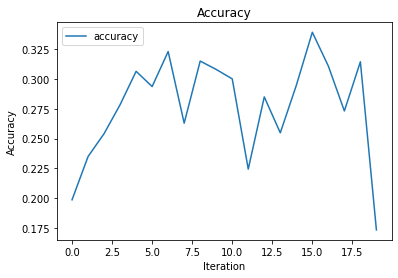

In [ ]:
q12_results(q2)  # w color jitter, lam_ul=10


Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, accuracy = 0.22119140625


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, accuracy = 0.26386719942092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, accuracy = 0.3057617247104645


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, accuracy = 0.23505859076976776


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, accuracy = 0.29570311307907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, accuracy = 0.2939453125


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, accuracy = 0.2901367247104645


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, accuracy = 0.22568359971046448


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, accuracy = 0.3177734315395355


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, accuracy = 0.2613281309604645


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, accuracy = 0.32636719942092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, accuracy = 0.2919921875


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, accuracy = 0.2906250059604645


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, accuracy = 0.32148438692092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, accuracy = 0.3438476622104645


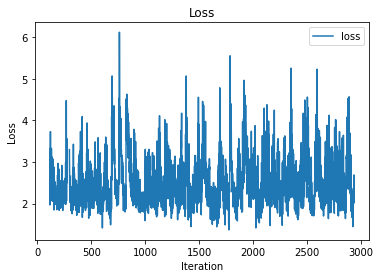

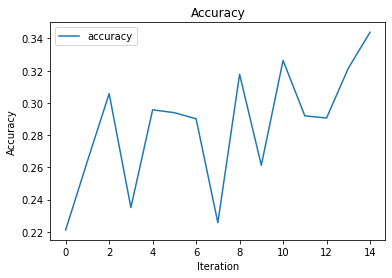

In [ ]:
q12_results(q2) # color_jit, lam_u = 1


Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, accuracy = 0.16708984971046448


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, accuracy = 0.22255858778953552


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, accuracy = 0.22714844346046448


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, accuracy = 0.24082031846046448


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, accuracy = 0.24531249701976776


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, accuracy = 0.15791015326976776


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, accuracy = 0.1923828125


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, accuracy = 0.2520507872104645


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, accuracy = 0.23291015625


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, accuracy = 0.30078125


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, accuracy = 0.17499999701976776


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, accuracy = 0.11181640625


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, accuracy = 0.23759765923023224


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, accuracy = 0.09785155951976776


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, accuracy = 0.21953125298023224


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16, accuracy = 0.27216798067092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17, accuracy = 0.2948242127895355


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18, accuracy = 0.3163085877895355


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19, accuracy = 0.32109373807907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20, accuracy = 0.20820312201976776


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21, accuracy = 0.306640625


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22, accuracy = 0.22158202528953552


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23, accuracy = 0.34648436307907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24, accuracy = 0.32861328125


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25, accuracy = 0.31962889432907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26, accuracy = 0.29638671875


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27, accuracy = 0.26542967557907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28, accuracy = 0.3207031190395355


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29, accuracy = 0.32011717557907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30, accuracy = 0.17841796576976776


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 31, accuracy = 0.28857421875


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 32, accuracy = 0.32880860567092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 33, accuracy = 0.30419921875


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 34, accuracy = 0.32685548067092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 35, accuracy = 0.2841796875


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 36, accuracy = 0.3414062559604645


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 37, accuracy = 0.3343749940395355


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 38, accuracy = 0.22871093451976776


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 39, accuracy = 0.3182617127895355


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 40, accuracy = 0.3077148497104645


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 41, accuracy = 0.2867187559604645


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 42, accuracy = 0.3661132752895355


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 43, accuracy = 0.30048829317092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 44, accuracy = 0.34453123807907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 45, accuracy = 0.37158203125


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 46, accuracy = 0.40449219942092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 47, accuracy = 0.33027344942092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 48, accuracy = 0.39091795682907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 49, accuracy = 0.38554686307907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 50, accuracy = 0.36699217557907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 51, accuracy = 0.40312498807907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 52, accuracy = 0.36083984375


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 53, accuracy = 0.3456054627895355


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 54, accuracy = 0.41015625


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 55, accuracy = 0.37617188692092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 56, accuracy = 0.40996092557907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 57, accuracy = 0.39863282442092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 58, accuracy = 0.42500001192092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 59, accuracy = 0.4227539002895355


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 60, accuracy = 0.4212890565395355


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 61, accuracy = 0.4251953065395355


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 62, accuracy = 0.4063476622104645


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 63, accuracy = 0.4400390684604645


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 64, accuracy = 0.4427734315395355


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 65, accuracy = 0.4330078065395355


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 66, accuracy = 0.44775390625


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 67, accuracy = 0.45244139432907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 68, accuracy = 0.43828123807907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 69, accuracy = 0.4569335877895355


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 70, accuracy = 0.41386717557907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 71, accuracy = 0.439453125


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 72, accuracy = 0.45068359375


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 73, accuracy = 0.44746094942092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 74, accuracy = 0.4691406190395355


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 75, accuracy = 0.44414061307907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 76, accuracy = 0.4708007872104645


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 77, accuracy = 0.4795898497104645


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 78, accuracy = 0.4803710877895355


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 79, accuracy = 0.4384765625


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 80, accuracy = 0.4588867127895355


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 81, accuracy = 0.45556640625


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 82, accuracy = 0.46904295682907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 83, accuracy = 0.484375


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 84, accuracy = 0.46923828125


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 85, accuracy = 0.4546875059604645


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 86, accuracy = 0.4608398377895355


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 87, accuracy = 0.451171875


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 88, accuracy = 0.4756835997104645


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 89, accuracy = 0.47822266817092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 90, accuracy = 0.48027342557907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 91, accuracy = 0.47314453125


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 92, accuracy = 0.4722656309604645


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 93, accuracy = 0.48613280057907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 94, accuracy = 0.47832030057907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 95, accuracy = 0.48193359375


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 96, accuracy = 0.47734373807907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 97, accuracy = 0.47529298067092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 98, accuracy = 0.4891601502895355


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 99, accuracy = 0.46601563692092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 100, accuracy = 0.48906248807907104


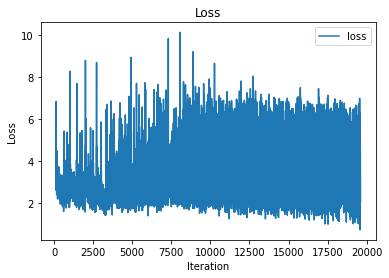

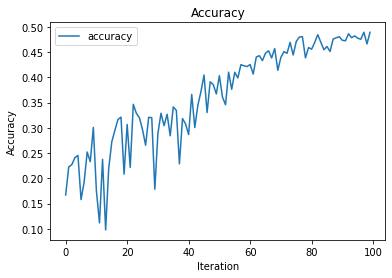

In [34]:
q12_results(q2)  # w gr_sc, lam_u=3

# paired data only

In [ ]:
class Net(nn.Module):
    def __init__(self, out_dim=128, hid_dim_full=128):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1, stride=2)
        self.conv5 = nn.Conv2d(32, 32, 1)
        self.conv6 = nn.Conv2d(32, 4, 1)

        self.conv_to_fc = 8 * 8 * 4
        self.fc1 = nn.Linear(self.conv_to_fc, hid_dim_full)
        self.fc2 = nn.Linear(hid_dim_full, int(hid_dim_full // 2))

        self.features = nn.Linear(int(hid_dim_full // 2), out_dim)
        self.last = nn.Linear(out_dim, 10)


    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))

        x = x.reshape(-1, self.conv_to_fc)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        features = self.features(x)

        return self.last(features)


class LabelsOnly(nn.Module):
    def __init__(self,):
        super(LabelsOnly, self).__init__()
        self.net = Net()


    def forward(self, x):
        return self.net(x)


    def get_accuracy(self, test_loader):
        accs = []
        self.net.eval()
        with torch.no_grad():
            for (x, l) in test_loader:
                p = self(x.to(device))
                pred_l = torch.argmax(p, dim=1).detach().cpu()
                acc = (pred_l == l).float().mean().item()
                accs.append(acc)
        return torch.Tensor(accs).mean()



    def fit(self, traindata, testdata, lr=5e-4, bs=256, num_epochs=15):

        optim = opt.Adam(self.parameters(), lr=lr)
        data_loader = torch.utils.data.DataLoader(traindata, bs, shuffle=True)
        test_loader = torch.utils.data.DataLoader(testdata, bs, shuffle=False)

        losses = []
        accs = []
        
        for i in tqdm(range(num_epochs)):
            self.net.train()
            for (x, l) in tqdm(data_loader):
                ul_mask = l == -1

                # supervised part
                p = self(x[~ul_mask].to(device))
                l_loss = F.cross_entropy(p, l[~ul_mask].to(device))

                loss = l_loss
                optim.zero_grad()
                loss.backward()
                optim.step()

                losses.append(loss.item())
            
            acc = self.get_accuracy(test_loader)
            print(f'Epoch {i + 1}, accuracy = {acc}')
            accs.append(acc)
        
        return np.array(losses), np.array(accs)

In [ ]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """

    model = LabelsOnly().to(device)
    losses, accs = model.fit(train_data, test_data)
    return losses, accs

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, accuracy = 0.21054688096046448


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, accuracy = 0.26591795682907104


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, accuracy = 0.3204101622104645


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, accuracy = 0.33906251192092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, accuracy = 0.36689454317092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, accuracy = 0.35371094942092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, accuracy = 0.396484375


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, accuracy = 0.40234375


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, accuracy = 0.41816407442092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, accuracy = 0.4161132872104645


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, accuracy = 0.40693360567092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, accuracy = 0.4312500059604645


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, accuracy = 0.42939454317092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, accuracy = 0.42402344942092896


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, accuracy = 0.4424804747104645


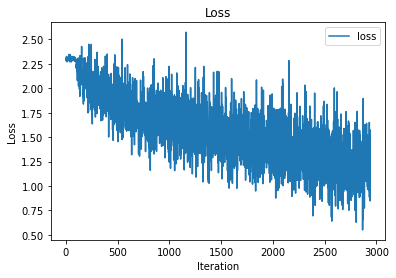

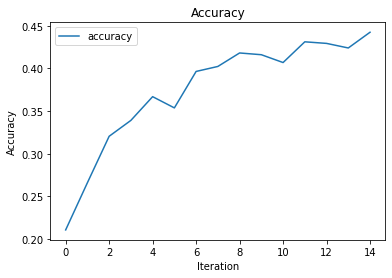

In [ ]:
q12_results(q2)

# Bonus

## The probabilistic model

*(this is a short summary of the model presented in ["Semi-supervised Learning with
Deep Generative Models"](https://arxiv.org/pdf/1406.5298.pdf))*

In the semi-supervised setting, the generative model is a little more complicated than vanilla VAE. In particular, it incorporates a new variable $y$ that represents the class of a digit $x$.

\begin{align*}
& p(x, y, z) = p(x \mid y, z) p(z) p(y) \\
& p(y) = Cat(y \mid \pi_0), \pi_0 = (1/10, \dots, 1/10) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid y, z) = \prod_{i=1}^D p_i(y, z)^{x_i} (1 - p_i(y, z))^{1 - x_i}
\end{align*}

## The first part of the objective

Whenever we train a probabilistic model with partial observations, we interpret the unobserved variables as latent variables. Then we marginalize them. In this case, the loss function splits into two terms: one for observed variables (we denote the set of indices of observed labels $P$), another for unobserved.

\begin{equation}
L(X, y) = \sum_{i \notin P} \log p(x_i) + \sum_{i \in P} \log p(x_i, y_i)
\end{equation}

Again, we can't compute the exact values of marginal likelihoods and resort to variational lower bound on likelihood. To compute lower bounds, we define the following variational approximation:

\begin{align*}
& q(y, z \mid x) = q(y \mid x) q(z \mid y, x)\\
& \\
& q(y \mid x) = Cat(y \mid \pi(x))\\
& q(z \mid y, x) = \mathcal N(z \mid \mu_\phi(x, y), \operatorname{diag}\sigma^2_\phi(y, x))
\end{align*}

Using the variational approximation, we will obtain two lower bounds.

First, the ELBO for $\log p(x_i, y_i)$ for the observed variables (this one is similar to ELBO of VAE).

\begin{equation}
\log p(x, y) = \log \mathbb E_{p(z)} p(x, y \mid z) \geq \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x)}
\end{equation}

Second, the ELBO for $\log p(x_i)$ for the unobserved variables.

\begin{equation}
\log p(x) = \log \mathbb E_{p(y)} \mathbb E_{p(z \mid y)} \log p(x\mid z, y)\geq \mathbb E_{q(y \mid x)} \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x) q(y \mid x)}
\end{equation}

Finally, the joint lower bound will be

\begin{equation}
\mathcal L(X, y) = \sum_{i \in P} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i)} + \sum_{i \notin P} \mathbb E_{q(y_i \mid x_i)} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i) q(y_i \mid x_i)}
\end{equation}

We will use reparametrized Monte-Carlo estimates to approximate expectation w.r.t. $z$. To approximate expectaion w.r.t. the discrete variable $y$ we will try three different options.

In [ ]:
def b(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of binary MNIST images
    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """